## HDCS Fall 22 internship - Stage C Graded Quiz
**CNN to Classify satelitte smage chips of Amazon**
Authot: Zakaria Jnayni
### Import libraries


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from sklearn.utils import shuffle
from PIL import Image
from tqdm import tqdm

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, Dense, LSTM, Flatten, MaxPooling2D, BatchNormalization, Dropout
from sklearn.metrics import f1_score
from sklearn import metrics

### Import data

In [2]:
# read the data
train_classes = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
sam_sub = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv')
train_classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
# define labels
labels_data = pd.DataFrame()
labels_data['tags'] = ['agriculture', 'artisinal_mine', 'bare_ground','blooming','blow_down','clear','cloudy','conventional_mine','cultivation','habitation','haze', 'partly_cloudy','primary','road','selective_logging','slash_burn','water']

# encode labels
encoder = LabelEncoder()
labels_data['encoded'] = encoder.fit_transform(labels_data)

# print encoded labels
labels_data

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,tags,encoded
0,agriculture,0
1,artisinal_mine,1
2,bare_ground,2
3,blooming,3
4,blow_down,4
5,clear,5
6,cloudy,6
7,conventional_mine,7
8,cultivation,8
9,habitation,9


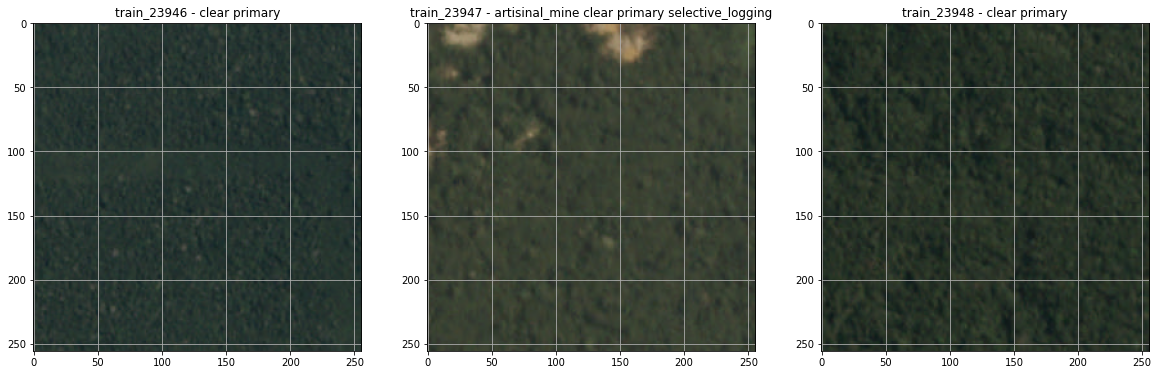

In [4]:
# show random images.
plt.rc('axes', grid = True)
_, ax = plt.subplots(1, 3, figsize=(20, 20))
random_img = np.random.randint(0,len(train_classes) - 3)
for i , (file, label) in enumerate(train_classes[random_img:random_img + 3].values):
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(file))
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('{} - {}'.format(file, label))
    
plt.show()

### Data processing

In [5]:
#define a dictionary of labels
label_map = {'agriculture': 0,
 'artisinal_mine': 1,
 'bare_ground': 2,
 'blooming': 3,
 'blow_down': 4,
 'clear': 5,
 'cloudy': 6,
 'conventional_mine': 7,
 'cultivation': 8,
 'habitation': 9,
 'haze': 10,
 'partly_cloudy': 11,
 'primary': 12,
 'road': 13,
 'selective_logging': 14,
 'slash_burn': 15,
 'water': 16}

In [6]:
# Split the data into X and Y
def preprocess(image_path, labels_df, size = (32, 32)):
    #shuffle data
    labels_df = shuffle(labels_df, random_state=0)
    X, Y = [], []
    for img_name, tags in labels_df.values:
        img = cv2.imread(f'{image_path}/{img_name}.jpg')
        img = cv2.resize(img, size)
        img = img / 255.
        labels = np.zeros(17)
        for t in tags.split(" "):
            labels[label_map[t]] = 1
        X.append(img)
        Y.append(labels)
    return np.array(X), np.array(Y)

In [7]:
X, Y = preprocess("/kaggle/input/planets-dataset/planet/planet/train-jpg", train_classes)

In [8]:
# Train Test split
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 1)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(32383, 32, 32, 3) (32383, 17) (8096, 32, 32, 3) (8096, 17)


In [9]:
# delete junk
import gc
del X, Y
gc.collect()

33

### Modeling

In [44]:
# Make the model
model = keras.Sequential()

model.add(Conv2D(32, 5, 2, activation = "relu", input_shape = (32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D())

model.add(Conv2D(64, 5, 2, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(17, activation = "sigmoid"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 32)        2432      
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 2, 64)          51264     
_________________________________________________________________
batch_normalization_10 (Batc (None, 2, 2, 64)          256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 2, 64)         

In [47]:
model.compile(loss = "binary_crossentropy", optimizer = 'Adam', metrics = ['accuracy'])
History = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10, batch_size = 32)

Epoch 1/10
1012/1012 [==============================] - 14s 13ms/step - loss: 0.1675 - accuracy: 0.0932 - val_loss: 0.2899 - val_accuracy: 0.4161
Epoch 2/10
1012/1012 [==============================] - 13s 13ms/step - loss: 0.1653 - accuracy: 0.0933 - val_loss: 6.6665 - val_accuracy: 0.0450
Epoch 3/10
1012/1012 [==============================] - 13s 13ms/step - loss: 0.1622 - accuracy: 0.0975 - val_loss: 0.1725 - val_accuracy: 0.3077
Epoch 4/10
1012/1012 [==============================] - 13s 13ms/step - loss: 0.1620 - accuracy: 0.0974 - val_loss: 0.1679 - val_accuracy: 0.3580
Epoch 5/10
1012/1012 [==============================] - 13s 12ms/step - loss: 0.1578 - accuracy: 0.0976 - val_loss: 0.3934 - val_accuracy: 0.2585
Epoch 6/10
1012/1012 [==============================] - 14s 14ms/step - loss: 0.1586 - accuracy: 0.0946 - val_loss: 0.3111 - val_accuracy: 0.4632
Epoch 7/10
1012/1012 [==============================] - 13s 13ms/step - loss: 0.1566 - accuracy: 0.0961 - val_loss: 2.4075 -

In [48]:
test_loss, test_accuracy = model.evaluate(x_val, y_val)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

253/253 [==============================] - 1s 4ms/step - loss: 1.5731 - accuracy: 0.4054
Test loss: 1.5730863809585571
Test accuracy: 0.4053853750228882
